# Agents with Memory

We have an email assistant that uses a router to triage emails and then passes the email to the agent for response generation. We've also evaluated it and added human-in-the-loop (HITL) to review specific tool calls. Now, we add memory, giving our assistant the ability to remember our HITL feedback!

![overview-img](img/overview_memory.png)

## Memory in LangGraph

### Thread-Scoped and Across-Thread Memory

First, it's worth explaining how [memory works in LangGraph](https://langchain-ai.github.io/langgraphjs/concepts/memory/). LangGraph offers two distinct types of memory that serve complementary purposes:

**Thread-Scoped Memory (Short-term)** operates within the boundaries of a single conversation thread. It's automatically managed as part of the graph's state and persisted through thread-scoped checkpoints. This memory type retains conversation history, uploaded files, retrieved documents, and other artifacts generated during the interaction. Think of it as the working memory that maintains context within one specific conversation, allowing the agent to reference earlier messages or actions without starting from scratch each time.

**Across-Thread Memory (Long-term)** extends beyond individual conversations, creating a persistent knowledge base that spans multiple sessions. This memory is stored as JSON documents in a memory store, organized by namespaces (like folders) and distinct keys (like filenames). Unlike thread-scoped memory, this information persists even after conversations end, enabling the system to recall user preferences, past decisions, and accumulated knowledge. This is what allows an agent to truly learn and adapt over time, rather than treating each interaction as isolated.

![short-vs-long-term-memory](img/short-vs-long.png)

The [Store](https://langchain-ai.github.io/langgraphjs/concepts/persistence/) is the foundation of this architecture, providing a flexible database where memories can be organized, retrieved, and updated. What makes this approach powerful is that regardless of which memory type you're working with, the same Store interface provides consistent access patterns. This allows your agent's code to remain unchanged whether you're using a simple in-memory implementation during development or a production-grade database in deployment. 

### LangGraph Store

LangGraph offers different [Store implementations depending on your deployment scenario](https://langchain-ai.github.io/langgraphjs/concepts/persistence/#memory-store):

1. **Pure In-Memory (e.g., notebooks)**:
   - Uses `import { InMemoryStore } from "@langchain/langgraph"`
   - Purely a JavaScript object in memory with no persistence
   - Data is lost when the process terminates
   - Useful for quick experiments and testing
   - Includes semantic search with cosine similarity

2. **Local Development with `langgraph dev`**:
   - Similar to InMemoryStore but with pseudo-persistence
   - Data is saved to the local filesystem between restarts
   - Lightweight and fast, no need for external databases
   - Semantic search uses cosine similarity for embedding comparisons
   - Great for development but not designed for production use

3. **LangGraph Platform or Production Deployments**:
   - Uses PostgreSQL with pgvector for production-grade persistence
   - Fully persistent data storage with reliable backups
   - Scalable for larger datasets
   - High-performance semantic search via pgvector
   - Default distance metric is cosine similarity (customizable)

Let's use the `InMemoryStore` here in the notebook! 

In [1]:
// Import or implement an in-memory store for development/testing
import { InMemoryStore } from "@langchain/langgraph";

const inMemoryStore = new InMemoryStore();

Memories are namespaced by an array, which in this specific example will be `[<user_id>, "memories"]`. The namespace array can be any length and represent anything—it does not have to be user specific.

In [2]:
const userId = "1";
const namespaceForMemory = [userId, "memories"];

We use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace (as defined above), and a key-value pair for the memory: the key is simply a unique identifier for the memory (`memoryId`), and the value (a plain JavaScript object) is the memory itself.

In [3]:
import { v4 as uuid4 } from 'uuid';

const memoryId = uuid4();
const memory = { food_preference: "I like pizza" };

await inMemoryStore.put(namespaceForMemory, memoryId, memory);

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as an array. The most recent memory is the last in the array. Each memory is an object with certain attributes, such as `namespace`, `key`, `value`, `created_at`, and `updated_at`. The most important attribute is typically `value`, which contains the actual memory data.

In [4]:
const memories: Record<string, any> = await inMemoryStore.search(namespaceForMemory);
console.log(memories.at(-1));

{
  value: { food_preference: 'I like pizza' },
  key: '5bc6d1d1-9f9c-4826-8715-54881c5fe1b5',
  namespace: [ '1', 'memories' ],
  createdAt: 2025-05-13T12:06:28.108Z,
  updatedAt: 2025-05-13T12:06:28.108Z,
  score: undefined
}


To use this in a graph, all you need to do is compile the graph with the store and a checkpointer:

```ts
import { InMemorySaver } from "@langchain/langgraph"; 

const checkpointer = new InMemorySaver();
// When compiling your graph, pass both checkpointer and store:
const graph = myGraph.compile({ checkpointer, store: inMemoryStore });
```

The store is then accessible in any node of the graph, as we'll see below!

## Adding Memory to our Assistant

Let's take our graph with HITL and add memory to it. This will be very similar to what we had previously, but we'll simply update memory in the store when we get feedback from the user.

![overview-img](img/HITL_flow_memory.png)

In [5]:
import { z } from "zod";
import { tool, type StructuredTool } from "@langchain/core/tools";
import { initChatModel } from "langchain/chat_models/universal";

// Email tool with correct properties
const emailSchema = z.object({
  recipient: z.string().describe("Email address of the recipient"),
  subject: z.string().describe("Clear and concise subject line for the email"),
  content: z.string().describe("Main body text of the email"),
});

const writeEmail = tool(async ({
  recipient,
  subject,
  content,
}: z.infer<typeof emailSchema>) => {
  return `Email draft created:
To: ${recipient}
Subject: ${subject}
${content}
[Draft saved. Ready to send or edit further.]`;
}, {
  name: "write_email",
  description:
    "Write an email draft based on provided information. Use this when the user wants to compose a new email message.",
  schema: emailSchema,
});


const RouterSchema = z.object({
  reasoning: z
    .string()
    .describe("Step-by-step reasoning behind the classification"),
  classification: z
    .enum(["ignore", "respond", "notify"])
    .describe(
      "The classification of an email: 'ignore' for irrelevant emails, " +
      "'notify' for important information that doesn't need a response, " +
      "'respond' for emails that need a reply",
    ),
});

// Calendar tool with correct properties
const scheduleMeetingSchema = z.object({
  title: z.string().describe("Meeting title"),
  attendees: z.array(z.string()).describe("List of attendees' emails"),
  startTime: z.string().describe("Meeting start time in ISO format"),
  endTime: z.string().describe("Meeting end time in ISO format"),
  description: z.string().optional().describe("Meeting description"),
});

const scheduleMeeting = tool(async (args: z.infer<typeof scheduleMeetingSchema>) => {
  const { title, attendees, startTime, endTime, description } = args;
  // Mock implementation
  return `Meeting "${title}" scheduled from ${startTime} to ${endTime} with ${attendees.length} attendees`;
}, {
  name: "schedule_meeting",
  description: "Schedule a meeting on the calendar",
  schema: scheduleMeetingSchema,
});

const availabilitySchema = z.object({
  startTime: z.string().describe("Start time in ISO format"),
  endTime: z.string().describe("End time in ISO format"),
});

const checkCalendarAvailability = tool(async (args: z.infer<typeof availabilitySchema>) => {
  const { startTime, endTime } = args;
  // Mock implementation
  return `Time slot from ${startTime} to ${endTime} is available`;
}, {
  name: "check_calendar_availability",
  description: "Check calendar availability for a specified time range",
  schema: availabilitySchema,
});

const Question = tool(
  async ({ content }: { content: string }) => {
    return `The user will see and can answer this question: ${content}`;
  },
  {
    name: "Question",
    description: "Ask the user a follow-up question",
    schema: z.object({
      content: z.string().describe("The question to ask the user"),
    }),
  },
);

// Define the doneSchema
const doneSchema = z.object({
  content: z.string().optional().describe("Optional completion message"),
});

const Done = tool(async () => {
  return "Task completed successfully. No further actions required.";
}, {
  name: "Done",
  description:
    "Signal that you've completed the current task and no further actions are needed.",
  schema: doneSchema,
});

const tools = [
  writeEmail,
  scheduleMeeting,
  checkCalendarAvailability,
  Question,
  Done,
];

const toolsByName = Object.fromEntries(tools.map((t) => [t.name, t])) as Record<string, StructuredTool>;

Now, this is the critical part! We don't capture any feedback from the user in our graph.

### Memory Management 

What we *want* to do is fairly straightforward: we want to add the feedback to the memory `Store`. If we compile our graph with the `Store`, we can access it in any node—so that's not a problem!

But we have to answer two questions:

* 1) How do we want the memory to be structured?
* 2) How do we want to update the memory?

For 1), we'll just store memories as a string to keep things simple. In the function below, we'll fetch memories from the store as a string and initialize with a default if it doesn't exist.

In [6]:
const defaultTriageInstructions = `
Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the \`notify\` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails that are worth responding to:
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
- Critical bug reports related to team's projects
- Requests from management requiring acknowledgment
- Client inquiries about project status or features
- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
- Personal reminders related to family (wife / daughter)
- Personal reminder related to self-care (doctor appointments, etc)
`;

In [7]:
// Default calendar preferences
const defaultCalPreferences = `
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
`;


In [8]:
const defaultResponsePreferences = `
Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or during the meeting
- When scheduling meetings, clearly state the specific day, date, and time proposed

When responding to meeting scheduling requests:
- If times are proposed, verify calendar availability for all time slots mentioned in the original email and then commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make it at the time proposed.
- If no times are proposed, then check your calendar for availability and propose multiple time options when available instead of selecting just one.
- Mention the meeting duration in your response to confirm you've noted it correctly.
- Reference the meeting's purpose in your response.
`;

In [9]:
/**
 * Get memory from the store or initialize with default if it doesn't exist.
 * @param store - The memory store instance
 * @param namespace - Array or tuple defining the memory namespace
 * @param defaultContent - Default content to use if memory doesn't exist
 * @returns The content of the memory profile, either from existing memory or the default
 */
async function getMemory(
  store,
  namespace,
  defaultContent,
) {
  // Search for existing memory with namespace and key
  const userPreferences = await store.get(namespace, "user_preferences");

  // If memory exists, return its content (the value)
  if (userPreferences) {
    return userPreferences.value ?? userPreferences;
  }

  // If memory doesn't exist, add it to the store and return the default content
  await store.put(namespace, "user_preferences", defaultContent);

  // Return the default content
  return defaultContent;
}

For 2) updating memory, we can use a few tricks from the [GPT-4.1 prompting guide](https://cookbook.openai.com/examples/gpt4-1_prompting_guide) to help us update the memory:

* For optimal performance, repeat the key instructions at the start and end of the prompt
* Create clear, explicit instructions 
* Use XML delimiters for structure
* Provide examples 

In [10]:
import { initChatModel } from "langchain/chat_models/universal";

// Memory update instructions as template strings
const MEMORY_UPDATE_INSTRUCTIONS = `
# Role and Objective
You are a memory profile manager for an email assistant agent that selectively updates user preferences based on feedback messages from human-in-the-loop interactions with the email assistant.

# Instructions
- NEVER overwrite the entire memory profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly contradicted by feedback messages
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original style
- Generate the profile as a string

# Reasoning Steps
1. Analyze the current memory profile structure and content
2. Review feedback messages from human-in-the-loop interactions
3. Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites, explicit feedback on assistant performance, user decisions to ignore certain emails)
4. Compare new information against existing profile
5. Identify only specific facts to add or update
6. Preserve all other existing information
7. Output the complete updated profile

# Example
<memory_profile>
RESPOND:
- wife
- specific questions
- system admin notifications
NOTIFY: 
- meeting invites
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</memory_profile>

<user_messages>
"The assistant shouldn't have responded to that system admin notification."
</user_messages>

<updated_profile>
RESPOND:
- wife
- specific questions
NOTIFY: 
- meeting invites
- system admin notifications
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</updated_profile>

# Process current profile for {namespace}
<memory_profile>
{current_profile}
</memory_profile>

Think step by step about what specific feedback is being provided and what specific information should be added or updated in the profile while preserving everything else.`;

const MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT = `
Remember:
- NEVER overwrite the entire profile
- ONLY make targeted additions or changes based on explicit feedback
- PRESERVE all existing information not directly contradicted
- Output the complete updated profile as a string
`;
/**
 * Update memory profile in the store.
 * @param store - The memory store instance
 * @param namespace - Array defining the memory namespace
 * @param messages - Array of messages to update the memory with
 */
async function updateMemory(
  store,
  namespace,
  messages
) {
  // Get the existing memory
  const userPreferences = await store.get(namespace, "user_preferences");

  // Prepare the prompt
  const prompt = [
    {
      role: "system",
      content: MEMORY_UPDATE_INSTRUCTIONS
        .replace("{current_profile}", userPreferences?.value ?? "")
        .replace("{namespace}", namespace.join(", ")),
    },
    {
      role: "user",
      content: "Think carefully and update the memory profile based upon these user messages:",
    },
    ...messages,
  ];
  const llm = await initChatModel(
    "openai:gpt-4.1",
    { temperature: 0 }
  );

  const llmWithTools = llm.bindTools(tools, { toolChoice: "required" });
  // Call the LLM
  const result = await llmWithTools.invoke(prompt);

  // Save the updated memory to the store
  await store.put(namespace, "user_preferences", result.content);
}

We set up the triage router as we had before.

In [11]:
import {
  END,
  Command,
} from "@langchain/langgraph";

// triage router node dependencies 
function parseEmail(email: {
  from_email: string;
  author: string;
  to_email: string;
  to: string;
  subject: string;
  page_content: string;
  email_thread: string;
}): {
  author: string;
  to: string;
  subject: string;
  emailThread: string;
} {
  try {
    // Try both possible key sets
    const author = email.from_email ?? email.author;
    const to = email.to_email ?? email.to;
    const subject = email.subject;
    const emailThread = email.page_content ?? email.email_thread;

    return { author, to, subject, emailThread };
  } catch (error) {
    console.error("Error parsing email:", error);
    throw new Error("Failed to parse email");
  }
}

const defaultBackground = `
I'm Lance, a software engineer at LangChain.
`;

// Agentic workflow triage user prompt
const triageUserPrompt = `
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}`;

const triageSystemPrompt = `
<Role>
Your role is to triage incoming emails based upon instructs and background information below.
</Role>

<Background>
{background}. 
</Background>

<Instructions>
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</Instructions>

<Rules>
{triage_instructions}
</Rules>
`;

function formatEmailMarkdown(
  subject: string,
  author: string,
  to: string,
  emailThread: string,
): string {
  return `## Email: ${subject}
**From**: ${author}
**To**: ${to}
${emailThread}`;
}

type EmailData = {
  id: string;
  thread_id: string;
  from_email: string;
  subject: string;
  page_content: string;
  send_time: string;
  to_email: string;
};

async function triageRouter(state) {
  const { author, to, subject, emailThread } = parseEmail(state.email_input);

  const emailMarkdown = formatEmailMarkdown(subject, author, to, emailThread);
  // Fix the string template replacement issue
  const userPrompt = triageUserPrompt
    .replace("{author}", author)
    .replace("{to}", to)
    .replace("{subject}", subject)
    .replace("{email_thread}", emailThread);
  // Fix the string template replacement issue
  const systemPrompt = triageSystemPrompt
    .replace("{background}", defaultBackground)
    .replace("{triage_instructions}", defaultTriageInstructions);

  // Await the model to be initialized first
  const model = await initChatModel("openai:gpt-4.1", { temperature: 0 });
  const routerModel = model.withStructuredOutput(RouterSchema);

  // Await the invoke result
  const result = await routerModel.invoke([
    { role: "system", content: systemPrompt },
    { role: "user", content: userPrompt },
  ]);

  const classification = result.classification;

  if (classification === "respond") {
    console.log("📧 Classification: RESPOND - This email requires a response");
    return new Command({
      goto: "response_agent",
      update: {
        classification_decision: result.classification,
        messages: [
          {
            role: "user",
            content: `Respond to the email: ${emailMarkdown}`,
          },
        ],
      },
    });
  } else if (classification === "ignore") {
    console.log("🚫 Classification: IGNORE - This email can be safely ignored");
    return new Command({
      goto: END,
      update: { classification_decision: classification },
    });
  } else if (classification === "notify") {
    console.log("🔔 Classification: NOTIFY - This email contains important information");
    return new Command({
      goto: "triage_interrupt_handler",
      update: { classification_decision: classification },
    });
  } else {
    return new Command({
      goto: END,
      update: { classification_decision: classification },
    });
  }
}

We only need to make a small change to the interrupt handler to update the memory when the user provides feedback. 

In [12]:
import { interrupt } from "@langchain/langgraph";

async function triageInterruptHandler(state, store) {
  const { author, to, subject, emailThread } = parseEmail(state.email_input);
  const emailMarkdown = formatEmailMarkdown(subject, author, to, emailThread);

  const messages = [
    {
      role: "user",
      content: `Email to notify user about: ${emailMarkdown}`,
    },
  ];

  const request = {
    action_request: {
      action: `Email Assistant: ${state.classification_decision}`,
      args: {},
    },
    config: {
      allow_ignore: true,
      allow_respond: true,
      allow_edit: true,
      allow_accept: true,
    },
    description: emailMarkdown,
  };

  const response = interrupt([request])[0];

  let goto: "response_agent" | "__end__";
  if (response.type === "response") {
    const userInput = response.args;
    // Save feedback to memory
    const memoryId = uuid4();
    await store.put(namespaceForMemory, memoryId, { feedback: userInput, email: state.email_input });
    messages.push({
      role: "user",
      content: `User wants to reply to the email. Use this feedback to respond: ${userInput}`,
    });
    goto = "response_agent";
  } else if (response.type === "ignore") {
    goto = END;
  } else if (response.type === "accept") {
    goto = "response_agent";
  } else if (response.type === "edit") {
    goto = "response_agent";
  } else {
    throw new Error(`Invalid response: ${JSON.stringify(response)}`);
  }

  return new Command({
    goto,
    update: { messages },
  });
}

### Incorporating Memory into LLM Responses

Now that we have memory managers set up, we can use the stored preferences when generating responses.

In [13]:
const HITL_MEMORY_TOOLS_PROMPT = `
1. write_email(recipient, subject, content) - Send emails to specified recipients
2. schedule_meeting(title, attendees, startTime, endTime, description) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Question(content) - Ask your executive a question about your next action. Useful to gain information on preferences, next steps, etc.
5. Done - E-mail has been sent
`;

const AGENT_SYSTEM_PROMPT_HITL_MEMORY = `
<Role>
You are a top-notch executive assistant. 
</Role>

<Tools>
You have access to the following tools to help manage communications and schedule:
{tools_prompt}
</Tools>

<Instructions>
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. If the incoming email asks the user a direct question and you do not have context to answer the question, use the Question tool to ask the user for the answer
4. For responding to the email, draft a response email with the write_email tool
5. For meeting requests, use the check_calendar_availability tool to find open time slots
6. To schedule a meeting, use the schedule_meeting tool. You should always do this before responding with an email, even if your executive has availability.
   - Today's date is """ + datetime.now().strftime("%Y-%m-%d") + """ - use this for scheduling meetings accurately
7. If you scheduled a meeting, then draft a short response email using the write_email tool
8. After using the write_email tool, the task is complete
9. If you have sent the email, then use the Done tool to indicate that the task is complete
</Instructions>

<Background>
{background}
</Background>

<Response Preferences>
{response_preferences}
</Response Preferences>

<Calendar Preferences>
{cal_preferences}
</Calendar Preferences>
`;

In [14]:
/**
 * LLM decides whether to call a tool or not.
 * @param state - The agent state
 * @param store - The memory store instance
 * @returns An object with the LLM's response messages
 */
async function llmCall(
  state,
  config
) {
  const store = config.store;
  // Get memory preferences
  const calPreferences = await getMemory(
    store,
    ["email_assistant", "cal_preferences"],
    defaultCalPreferences,
  );

  const responsePreferences = await getMemory(
    store,
    ["email_assistant", "response_preferences"],
    defaultResponsePreferences,
  );

  // Set up system prompt for the agent
  const systemPrompt = AGENT_SYSTEM_PROMPT_HITL_MEMORY
    .replace("{tools_prompt}", HITL_MEMORY_TOOLS_PROMPT)
    .replace("{background}", defaultBackground)
    .replace("{response_preferences}", responsePreferences)
    .replace("{cal_preferences}", calPreferences);

  // Create full message history for the agent
  const allMessages = [
    { role: "system", content: systemPrompt },
    ...state.messages,
  ];

  const model = await initChatModel("openai:gpt-4.1", { temperature: 0 });
  const llmWithTools = model.bindTools(tools, { toolChoice: "required" });
  // Run the LLM with the messages
  const result = await llmWithTools.invoke(allMessages);

  // Return the AIMessage result
  return {
    messages: [result],
  };
}

### Memory Integration in the Interrupt Handler

Similarly, we add memory to the interrupt handler! 

In [15]:
/**
 * Creates an interrupt for human review of tool calls.
 * @param state - The agent state
 * @param store - The memory store instance
 * @returns Command object for the next node and state update
 */
async function interruptHandler(
  state,
  config
) {
  const store = config.store;
  const result = [];
  let goto = "llm_call";

  // Iterate over the tool calls in the last message
  for (const toolCall of state.messages[state.messages.length - 1].tool_calls) {
    const hitlTools = ["write_email", "schedule_meeting", "Question"];

    // If tool is not in our HITL list, execute it directly without interruption
    if (!hitlTools.includes(toolCall.name)) {
      const tool = toolsByName[toolCall.name];
      const observation = await tool.invoke(toolCall.args);
      result.push({ role: "tool", content: observation, tool_call_id: toolCall.id });
      continue;
    }

    // Get original email from email_input in state
    const emailInput = state.email_input;
    const { author, to, subject, emailThread } = parseEmail(emailInput);
    const originalEmailMarkdown = formatEmailMarkdown(subject, author, to, emailThread);

    function formatForDisplay(state, toolCall): string {
      // Initialize empty display
      let display = "";

      // Add tool call information based on tool type
      switch (toolCall.name) {
        case "write_email":
          display += `# Email Draft

**To**: ${toolCall.args.to}
**Subject**: ${toolCall.args.subject}

${toolCall.args.content}
`;
          break;

        case "schedule_meeting":
          display += `# Calendar Invite

**Meeting**: ${toolCall.args.title}
**Attendees**: ${toolCall.args.attendees?.join(", ")}
**Start time**: ${toolCall.args.startTime}
**End time**: ${toolCall.args.endTime}
`;
          break;

        case "Question":
          // Special formatting for questions to make them clear
          display += `# Question for User

${toolCall.args.content}
`;
          break;

        default:
          // Generic format for other tools
          display += `# Tool Call: ${toolCall.name}

Arguments:
${JSON.stringify(toolCall.args, null, 2)}
`;
      }

      return display;
    }
    // Format tool call for display and prepend the original email
    const toolDisplay = formatForDisplay(state, toolCall);
    const description = originalEmailMarkdown + toolDisplay;

    // Configure what actions are allowed in Agent Inbox
    let config;
    if (toolCall.name === "write_email" || toolCall.name === "schedule_meeting") {
      config = {
        allow_ignore: true,
        allow_respond: true,
        allow_edit: true,
        allow_accept: true,
      };
    } else if (toolCall.name === "Question") {
      config = {
        allow_ignore: true,
        allow_respond: true,
        allow_edit: false,
        allow_accept: false,
      };
    } else {
      throw new Error(`Invalid tool call: ${toolCall.name}`);
    }

    // Create the interrupt request
    const request = {
      action_request: {
        action: toolCall.name,
        args: toolCall.args,
      },
      config,
      description,
    };

    // Send to Agent Inbox and wait for response
    const [response] = await interrupt([request]);

    // Handle the responses
    if (response.type === "accept") {
      const tool = toolsByName[toolCall.name];
      const observation = await tool.invoke(toolCall.args);
      result.push({ role: "tool", content: observation, tool_call_id: toolCall.id });
    } else if (response.type === "edit") {
      const tool = toolsByName[toolCall.name];
      const editedArgs = response.args;
      const initialToolCall = `${toolCall.name}: ${JSON.stringify(toolCall.args)}`;
      const aiMessage = state.messages[state.messages.length - 1];
      const currentId = toolCall.id;

      // Replace the original tool call with the edited one
      aiMessage.tool_calls = [
        ...aiMessage.tool_calls.filter(tc => tc.id !== currentId),
        { type: "tool_call", name: toolCall.name, args: editedArgs, id: currentId }
      ];

      const observation = await tool.invoke(editedArgs);
      result.push({ role: "tool", content: observation, tool_call_id: currentId });

      // Update memory
      if (toolCall.name === "write_email") {
        await updateMemory(store, ["email_assistant", "response_preferences"], [
          {
            role: "user",
            content: `User edited the email response. Here is the initial email generated by the assistant: ${initialToolCall}. Here is the edited email: ${JSON.stringify(editedArgs)}. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else if (toolCall.name === "schedule_meeting") {
        await updateMemory(store, ["email_assistant", "cal_preferences"], [
          {
            role: "user",
            content: `User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: ${initialToolCall}. Here is the edited calendar invitation: ${JSON.stringify(editedArgs)}. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else {
        throw new Error(`Invalid tool call: ${toolCall.name}`);
      }
    } else if (response.type === "ignore") {
      let ignoreContent = "";
      if (toolCall.name === "write_email") {
        ignoreContent = "User ignored this email draft. Ignore this email and end the workflow.";
        goto = END;
        result.push({ role: "tool", content: ignoreContent, tool_call_id: toolCall.id });
        await updateMemory(store, ["email_assistant", "triage_preferences"], [
          ...state.messages,
          ...result,
          {
            role: "user",
            content: `The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else if (toolCall.name === "schedule_meeting") {
        ignoreContent = "User ignored this calendar meeting draft. Ignore this email and end the workflow.";
        result.push({ role: "tool", content: ignoreContent, tool_call_id: toolCall.id });
        goto = END;
        await updateMemory(store, ["email_assistant", "triage_preferences"], [
          ...state.messages,
          ...result,
          {
            role: "user",
            content: `The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else if (toolCall.name === "Question") {
        ignoreContent = "User ignored this question. Ignore this email and end the workflow.";
        result.push({ role: "tool", content: ignoreContent, tool_call_id: toolCall.id });
        goto = END;
        await updateMemory(store, ["email_assistant", "triage_preferences"], [
          ...state.messages,
          ...result,
          {
            role: "user",
            content: `The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else {
        throw new Error(`Invalid tool call: ${toolCall.name}`);
      }
    } else if (response.type === "response") {
      const userFeedback = response.args;
      if (toolCall.name === "write_email") {
        result.push({
          role: "tool",
          content: `User gave feedback, which can we incorporate into the email. Feedback: ${userFeedback}`,
          tool_call_id: toolCall.id
        });
        await updateMemory(store, ["email_assistant", "response_preferences"], [
          ...state.messages,
          ...result,
          {
            role: "user",
            content: `User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else if (toolCall.name === "schedule_meeting") {
        result.push({
          role: "tool",
          content: `User gave feedback, which can we incorporate into the meeting request. Feedback: ${userFeedback}`,
          tool_call_id: toolCall.id
        });
        await updateMemory(store, ["email_assistant", "cal_preferences"], [
          ...state.messages,
          ...result,
          {
            role: "user",
            content: `User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: ${MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}.`
          }
        ]);
      } else if (toolCall.name === "Question") {
        result.push({
          role: "tool",
          content: `User answered the question, which we can use for any follow up actions. Feedback: ${userFeedback}`,
          tool_call_id: toolCall.id
        });
      } else {
        throw new Error(`Invalid tool call: ${toolCall.name}`);
      }
    }
  }

  // Update the state
  const update = { messages: result };
  return new Command({ goto, update });
}

The rest is the same as before!

In [16]:
import { StateGraph, START, END } from "@langchain/langgraph";
import { BaseMessage, isAIMessage, isHumanMessage } from "@langchain/core/messages";
import { Messages, addMessages } from "@langchain/langgraph";
import { MemorySaver, InMemoryStore } from "@langchain/langgraph";

import "@langchain/langgraph/zod";

import { z } from "zod";

// Define proper state schema
const MessagesState = z.object({
  messages: z
    .custom<BaseMessage[]>()
    .default(() => [])
    .langgraph.reducer<Messages>((left, right) => addMessages(left, right)),
});

// Extend MessagesState for our email agent
const EmailAgentState = MessagesState.extend({
  email_input: z.any(),
  classification_decision: z
    .enum(["ignore", "respond", "notify", "error"])
    .nullable()
    .default(null),
});

// Create shouldContinue function for conditional edges
function shouldContinue(state) {
  const messages = state.messages;
  if (!messages || messages.length === 0) return END;

  const lastMessage = messages[messages.length - 1];

  if (isAIMessage(lastMessage) && lastMessage.tool_calls.length > 0) {
    // Check if any tool call is the "Done" tool
    if (lastMessage.tool_calls.some(toolCall => toolCall.name === "Done")) {
      return END;
    }
    return "interrupt_handler";
  }

  return END;
}

// Build the agent workflow using the graph builder already defined
const agentBuilder = new StateGraph(EmailAgentState)
  .addNode("llm_call", llmCall)
  .addNode("interrupt_handler", interruptHandler)
  .addEdge(START, "llm_call")
  .addConditionalEdges("llm_call", shouldContinue)
  .addEdge("interrupt_handler", "llm_call");


// Compile the agent
const responseAgent = agentBuilder.compile();

const StateSchema = z.object({
  email_input: z.any(),
  classification_decision: z.string().optional(),
  messages: z.array(z.any()).default([]).langgraph.reducer(addMessages),
});

// 2. Use z.infer for the type (optional, for TS type safety)
type State = z.infer<typeof StateSchema>;

// Build overall workflow with store and checkpointer
const overallWorkflow = new StateGraph(StateSchema)
  .addNode("triage_router", triageRouter)
  .addNode("triage_interrupt_handler", triageInterruptHandler)
  .addNode("response_agent", responseAgent)
  .addEdge(START, "triage_router")
  .addConditionalEdges(
    "triage_router",
    (state) => {
      const classification = state.classification_decision;
      if (classification === "respond") {
        return "response_agent";
      } else if (classification === "notify") {
        return "triage_interrupt_handler";
      } else {
        return END;
      }
    }
  )
  .addConditionalEdges(
    "triage_interrupt_handler",
    (state) => {
      const messages = state.messages;
      if (!messages || messages.length === 0) return END;
      const lastMessage = messages[messages.length - 1];
      if (
        isHumanMessage(lastMessage) &&
        typeof lastMessage.content === "string" &&
        lastMessage.content.includes("User wants to reply to the email")
      ) {
        return "response_agent";
      }
      return END;
    }
  )
  .addEdge("response_agent", END);

// Compile the overall workflow
const store = new InMemoryStore();
const checkpointer = new MemorySaver();

const emailAssistant = overallWorkflow.compile({ store, checkpointer });

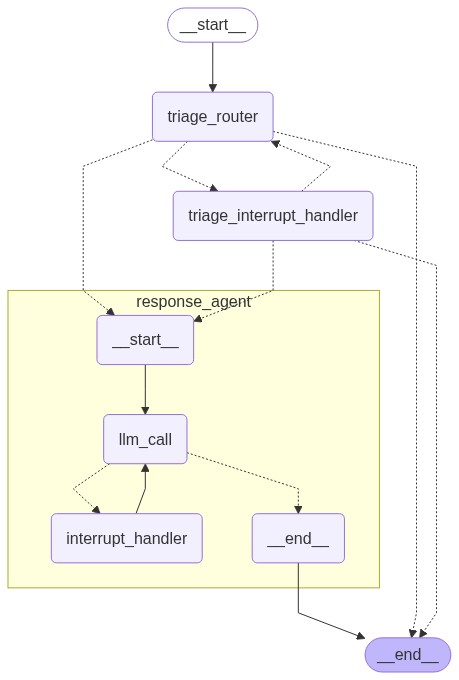

In [17]:
import * as tslab from "tslab";

const drawnGraph = await emailAssistant.getGraphAsync({ xray: true })

const image = await drawnGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Testing the agent with memory

Now that we've implemented memory into our email assistant, let's test how the system learns from user feedback and adapts over time. This testing section explores how different types of user interactions create distinct memory updates that improve the assistant's future performance.

The key questions we're answering through these tests:
1. How does the system capture and store user preferences?
2. How do these stored preferences affect future decisions?
3. What patterns of interaction lead to which types of memory updates?

First, let's build a helper function to display memory content so we can track how it evolves throughout our tests:

In [18]:
// Helper function to display memory content
async function displayMemoryContent(
  store,
  namespace,
) {
  console.log("\n======= CURRENT MEMORY CONTENT =======");
  if (namespace) {
    const memory = await store.get(namespace, "user_preferences");
    if (memory) {
      console.log(`\n--- ${namespace[1]} ---`);
      console.log({ preferences: memory.value });
    } else {
      console.log(`\n--- ${namespace[1]} ---`);
      console.log("No memory found");
    }
  } else {
    const namespaces = [
      ["email_assistant", "triage_preferences"],
      ["email_assistant", "response_preferences"],
      ["email_assistant", "cal_preferences"],
      ["email_assistant", "background"],
    ];
    for (const ns of namespaces) {
      const memory = await store.get(ns, "user_preferences");
      if (memory) {
        console.log(`\n--- ${ns[1]} ---`);
        console.log({ preferences: memory.value });
      } else {
        console.log(`\n--- ${ns[1]} ---`);
        console.log("No memory found");
      }
    }
    console.log("=======================================\n");
  }
}
// Initialize all user preference memories with their defaults
await getMemory(store, ["email_assistant", "triage_preferences"], defaultTriageInstructions);
await getMemory(store, ["email_assistant", "cal_preferences"], defaultCalPreferences);
await getMemory(store, ["email_assistant", "response_preferences"], defaultResponsePreferences);

// Display all user preference memories
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);
await displayMemoryContent(store, ["email_assistant", "cal_preferences"]);
await displayMemoryContent(store, ["email_assistant", "response_preferences"]);


======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacation\n' +
    '- Build system notifications or deployments\n' +
    '- Project status updates without action items\n' +
    '- Important company announcements\n' +
    '- FYI emails that contain relevant information for current projects\n' +
    '- HR Department deadline reminders\n' +
    '- Subscription status / renewal reminders\n' +
    '- GitHub notifications\n' +
    '\n' +
    'Emails that are worth responding to:\n' +
    '- Direct questions from team mem

### Accept `write_email` and `schedule_meeting`

Our first test examines what happens when a user accepts the agent's actions without modification. This baseline case helps us understand how the system behaves when no feedback is provided:

1. We'll use the same tax planning email from our previous tests
2. The system will classify it as "RESPOND" and propose scheduling a meeting
3. We'll accept the meeting schedule without changes
4. The agent will generate an email confirming the meeting
5. We'll accept the email without changes

This test demonstrates the default behavior of our memory-enabled system. When a user simply accepts proposed actions, we expect minimal or no memory updates since there's no explicit feedback to learn from. However, the system will still leverage existing memory (if any) when generating its responses.

In [19]:
import { v4 as uuidv4 } from "uuid";

// Respond - Meeting Request Email
const emailInputRespond = {
  to: "Lance Martin <lance@company.com>",
  author: "Project Manager <pm@client.com>",
  subject: "Tax season let's schedule call",
  email_thread: `Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager`
};

const threadId1 = uuidv4();
const threadConfig1 = { configurable: { thread_id: threadId1 } };

// Compile the graph
console.log("Running the graph until the first interrupt...");
let interruptObject: any = null;
const stream = await emailAssistant.stream(
  { email_input: emailInputRespond },
  threadConfig1,
)
for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Display all user preference memories
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);
await displayMemoryContent(store, ["email_assistant", "cal_preferences"]);
await displayMemoryContent(store, ["email_assistant", "response_preferences"]);

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Strategies Discussion',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:45:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacatio

#### Accept the `schedule_meeting` tool call

As we examine the initial `schedule_meeting` proposal, note how the system uses existing memory to inform its decisions:

1. The default calendar preferences show a preference for 30-minute meetings, though the email requests 45 minutes
2. The agent still proposes a 45-minute meeting, respecting the sender's specific request
3. We accept this proposal without modification to see if simple acceptance triggers any memory updates

After running this step, we'll check the memory contents to confirm whether acceptance alone leads to memory updates. Simple acceptance represents the baseline user experience - the system works as intended without requiring adjustments.

In [20]:
console.log(`\nSimulating user accepting the ${interruptObject.value[0].action_request.action} tool call...`);

// Simulate user accepting the tool call
const stream = await emailAssistant.stream(
  new Command({ resume: [{ type: "accept" }] }),
  threadConfig1,
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// After accepting, check memory contents
// Adjust the namespace as needed for your memory structure
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);
await displayMemoryContent(store, ["email_assistant", "cal_preferences"]);
await displayMemoryContent(store, ["email_assistant", "response_preferences"]);


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'write_email',
  args: {
    recipient: 'pm@client.com',
    subject: "Re: Tax season let's schedule call",
    content: 'Hi,\n' +
      '\n' +
      'Thank you for reaching out. I’ve scheduled a 45-minute call for us on Tuesday, June 11th at 2:00 PM to discuss tax planning strategies for this year. Please let me know if this time does not work for you, and I can suggest alternative slots on Tuesday or Thursday afternoon.\n' +
      '\n' +
      'Looking forward to your suggestions.\n' +
      '\n' +
      'Best regards,\n' +
      'Lance'
  }
}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '\n' +
    "There are also other things t

#### Accept the `write_email` tool call

Now we'll accept the email draft that confirms the meeting scheduling:

1. The email draft is generated with knowledge of our calendar preferences
2. It includes details about the meeting time, duration, and purpose
3. We'll accept it without changes to complete the baseline test case

After accepting, we'll check all memory stores to see if any updates occurred. As expected, simply accepting the agent's proposals doesn't provide strong learning signals - there's no clear feedback about what the user likes or dislikes about the agent's approach.

The trace link shows the complete workflow execution, where we can see that the memory is used in the LLM call for response generation, but no memory updates occur, which is the expected behavior for simple acceptances.

In [21]:
console.log(`\nSimulating user accepting the ${interruptObject.value[0].action_request.action} tool call...`);

// Simulate user accepting the tool call
const stream = await emailAssistant.stream(
  new Command({ resume: [{ type: "accept" }] }),
  threadConfig1,
);

for await (const chunk of stream) {
  // Inspect response_agent's most recent message
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// After accepting, check memory contents
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);
await displayMemoryContent(store, ["email_assistant", "cal_preferences"]);
await displayMemoryContent(store, ["email_assistant", "response_preferences"]);


Simulating user accepting the write_email tool call...
AIMessage {
  "id": "chatcmpl-BWih30uBSwKER93UCcYD27oDcgbIt",
  "content": "",
  "additional_kwargs": {
    "tool_calls": [
      {
        "id": "call_B2jn6YhqkUi4kxXzb8ByDfeK",
        "type": "function",
        "function": "[Object]"
      }
    ]
  },
  "response_metadata": {
    "tokenUsage": {
      "promptTokens": 1613,
      "completionTokens": 39,
      "totalTokens": 1652
    },
    "finish_reason": "tool_calls",
    "model_name": "gpt-4.1-2025-04-14",
    "usage": {
      "prompt_tokens": 1613,
      "completion_tokens": 39,
      "total_tokens": 1652,
      "prompt_tokens_details": {
        "cached_tokens": 1408,
        "audio_tokens": 0
      },
      "completion_tokens_details": {
        "reasoning_tokens": 0,
        "audio_tokens": 0,
        "accepted_prediction_tokens": 0,
        "rejected_prediction_tokens": 0
      }
    },
    "system_fingerprint": "fp_beec22d258"
  },
  "tool_calls": [
    {
      "name"

We can look at the full messages, and the trace: 

https://smith.langchain.com/public/86ff6474-29fe-452e-8829-b05a91b458eb/r

You'll notice that memory is used in the LLM call to respond. 

But the memory store *not* updated, because we haven't added any feedback via HITL.

### Edit `write_email` and `schedule_meeting`

This test explores how the system learns from direct edits to its proposed actions. When users modify the agent's suggestions, it creates clear, specific learning signals about their preferences:

1. We'll use the same tax planning email as before
2. When the agent proposes a 45-minute meeting, we'll edit it to:
   - Change the duration to 30 minutes (matching our stored preference)
   - Make the subject line more concise
3. When the agent drafts an email, we'll edit it to be:
   - Shorter and less formal
   - Structured differently

Edits provide the most explicit feedback about user preferences, letting the system learn exactly what changes are desired. We expect to see specific, targeted updates to our memory stores that reflect these edits.

In [22]:
// Same email as before
const emailInputRespond = {
  to: "Lance Martin <lance@company.com>",
  author: "Project Manager <pm@client.com>",
  subject: "Tax season let's schedule call",
  email_thread: `Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager`
};

const threadId2 = uuidv4();
const threadConfig2 = { configurable: { thread_id: threadId2 } };

console.log("Running the graph until the first interrupt...");
const stream = await emailAssistant.stream(
  { email_input: emailInputRespond },
  threadConfig2,
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Strategies Call',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:45:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}


#### Edit the `schedule_meeting` tool call

When we edit the meeting proposal, we're providing direct, explicit feedback about our preferences. This creates a significant learning opportunity for the system:

1. The agent initially proposes a 45-minute meeting (the duration requested in the email)
2. We edit it to 30 minutes and simplify the subject from "Tax Planning Strategies Discussion" to "Tax Planning Discussion"
3. This creates clear, specific feedback about our time preferences and naming conventions

After the edit, we'll check the calendar preferences memory store to see how it's updated. The memory update should capture both:
- Our preference for shorter 30-minute meetings
- Our preference for more concise meeting subjects

The trace reveals the precise memory update logic, showing how the system analyzes the difference between its proposal and our edits to extract meaningful patterns and preferences. We can see the detailed justification for each memory update, ensuring transparency in the learning process.

In [23]:
console.log("\nSimulating user editing the schedule_meeting tool call...");

// 30 minutes instead of 45
const editedScheduleArgs: z.infer<typeof scheduleMeetingSchema> = {
  attendees: ["pm@client.com", "lance@company.com"],
  title: "Tax Planning Discussion",
  startTime: new Date("2025-05-06T14:00:00").toISOString(),
  endTime: new Date("2025-05-06T14:30:00").toISOString(),
};

const stream = await emailAssistant.stream(
  new Command({ resume: [{ type: "edit", args: editedScheduleArgs }] }),
  threadConfig2,
);

for await (const chunk of stream) {
  // Inspect response_agent's most recent message
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after editing schedule_meeting
console.log("\nChecking memory after editing schedule_meeting:");
await displayMemoryContent(store, ["email_assistant", "cal_preferences"]);


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'write_email',
  args: {
    recipient: 'pm@client.com',
    subject: "Re: Tax season let's schedule call",
    content: 'Hi,\n' +
      '\n' +
      'Thank you for reaching out regarding tax planning strategies. I am available next week on both Tuesday and Thursday afternoon. Please let me know your preferred time on either day, and I will confirm the meeting for a 45-minute discussion.\n' +
      '\n' +
      'Looking forward to your suggestions.\n' +
      '\n' +
      'Best regards,\n' +
      'Lance'
  }
}

Checking memory after editing schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    '30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n' +
    '\n' +
    'When scheduling meetings, use the term "Discussion" instead of "Call" in the meeting title when appropriate.

Looking at the memory after editing the calendar invitation, we can see that it's been updated:

1. The system has identified that we prefer 30-minute meetings over longer durations
2. It's also captured our preference for concise meeting subjects

What's particularly impressive about this memory update is:
- It doesn't just record our specific edit, but generalizes to a broader preference pattern
- It preserves all existing memory content while adding the new information
- It extracts multiple preference signals from a single edit interaction

Now, let's edit the email draft to see how the system captures different types of communication preferences:

In [24]:
// Display current response_preferences memory before editing
console.log(await displayMemoryContent(store, ["email_assistant", "response_preferences"]));

// Now simulate user editing the write_email tool call
console.log("\nSimulating user editing the write_email tool call...");
const editedEmailArgs = {
  recipient: "pm@client.com",
  subject: "Re: Tax season let's schedule call",
  content: `Thanks! I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?

Best regards,
Lance Martin`
};

const stream = await emailAssistant.stream(
  new Command({ resume: [{ type: "edit", args: editedEmailArgs }] }),
  threadConfig2
);

for await (const chunk of stream) {
  // Inspect response_agent's most recent message
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after editing write_email
console.log("\nChecking memory after editing write_email:");

console.log(await displayMemoryContent(store, ["email_assistant", "response_preferences"]));


======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{
  preferences: '\n' +
    'Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n' +
    '\n' +
    'When responding to technical questions that require investigation:\n' +
    '- Clearly state whether you will investigate or who you will ask\n' +
    "- Provide an estimated timeline for when you'll have more information or complete the task\n" +
    '\n' +
    'When responding to event or conference invitations:\n' +
    '- Always acknowledge any mentioned deadlines (particularly registration deadlines)\n' +
    '- If workshops or specific topics are mentioned, ask for more specific details about them\n' +
    '- If discounts (group or early bird) are mentioned, explicitly request information about them\n' +
    "- Don't commit \n" +
    '\n' +
    'When responding to collaboration or project-related requests:\n' 

Our email edit reveals even more sophisticated learning capabilities:

1. We've dramatically shortened and simplified the email content
2. We've changed the tone to be more casual
3. We've added a question asking for confirmation rather than assuming the time works
4. We've slightly altered the meeting details (day and time)

Looking at the updated memory, we can see that the system has extracted a key insight about our communication style:

```
When scheduling a meeting, ask the recipient to confirm if the proposed time works for them, rather than assuming and stating the meeting is already scheduled.
```

This demonstrates the system's ability to:
- Analyze our edit not just at a superficial level, but to understand intent
- Extract generalizable principles from specific examples
- Preserve all existing guidance while adding new insights
- Maintain the organization and structure of the memory

These targeted, high-quality memory updates will improve all future interactions without requiring repeated corrections.

In [25]:
const state = await emailAssistant.getState(threadConfig2);
for (const m of state.values.messages) {
  console.log(m);
}

HumanMessage {
  "id": "b16e3a56-7cc0-40a6-a55d-16da213eb4e8",
  "content": "Respond to the email: ## Email: Tax season let's schedule call\n**From**: Project Manager <pm@client.com>\n**To**: Lance Martin <lance@company.com>\nLance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager",
  "additional_kwargs": {},
  "response_metadata": {}
}
AIMessage {
  "id": "chatcmpl-BWih5k13lXDuOEyIc1WpDdrZCp69k",
  "content": "",
  "additional_kwargs": {
    "tool_calls": [
      {
        "id": "call_fyTul7kj2d3QhRvQyOQaRrRr",
        "type": "function",
        "function": "[Object]"
      },
      {
        "id": "call_esPScN15TyiJwN7IVonoPjR1",
        "type": "function",
        "function": "[Object]"
      }
    ]
  },
  "respo

## Ignore `write_email`, `schedule_meeting`, and `question`

This test explores how the system learns from rejection. When users ignore (reject) the agent's suggestions, it creates a strong signal about content they don't want to handle:

1. We'll first test ignoring a `schedule_meeting` request entirely
2. Then we'll test accepting a meeting but ignoring the follow-up email
3. Finally, we'll test ignoring a `question` for a different email context

These rejection signals help the system learn what types of emails and actions a user prefers not to deal with, leading to more appropriate triage decisions in the future. We expect significant updates to the triage preferences memory after each ignore action.

In [26]:
// Respond - Meeting Request Email
const emailInputRespond3 = {
  to: "Lance Martin <lance@company.com>",
  author: "Project Manager <pm@client.com>",
  subject: "Tax season let's schedule call",
  email_thread: `Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager`
};

// Compile the graph
const threadId3 = uuidv4();
const threadConfig3 = { configurable: { thread_id: threadId3 } };

// Run the graph until the first interrupt
// Email will be classified as "respond"
// Agent will create a schedule_meeting and write_email tool call
console.log("Running the graph until the first interrupt...");
const stream = await emailAssistant.stream(
  { email_input: emailInputRespond3 },
  threadConfig3,
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after first interrupt
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Discussion',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:45:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacation\n' +
    

#### Ignore the `schedule_meeting` tool call

When we ignore a meeting scheduling request, we're signaling that we don't want to handle this type of email through the assistant. This creates a powerful learning opportunity about our triage preferences:

1. The assistant initially classified the tax planning email as "RESPOND"
2. But by ignoring the scheduling request, we indicate we'd prefer not to handle this type of email
3. The system needs to update its triage classification preferences to reflect this rejection

After ignoring the request, we'll check the triage preferences memory to see how the rejection affected the system's understanding. The memory update should show a new pattern added to the "not worth responding to" section, specifically about tax planning calls or similar recurring discussions.

The trace shows how the system processes this rejection, identifies the pattern, and updates the memory with specific justification for why this type of email should be classified differently in the future.

In [27]:
console.log(`\nSimulating user ignoring the ${interruptObject.value[0].action_request.action} tool call...`);
const stream = await emailAssistant.stream(
  new Command({ resume: [{ type: "ignore" }] }),
  threadConfig3,
);

for await (const chunk of stream) {
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after ignoring first tool call
console.log("\nChecking memory after ignoring first tool call:");
await displayMemoryContent(store, ["email_assistant", "triage_preferences"]);


Simulating user ignoring the write_email tool call...

Checking memory after ignoring first tool call:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '- Requests to schedule tax planning or financial strategy calls\n' +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacation\n' +
    '- Build system notifications or deployments\n' +
    '- Project status updates without action items\n' +
    '- Important company announcements\n' +
    '- FYI emails that contain relevant information for current projects\n' +
    '- HR Department

Looking at the memory update after ignoring the `schedule_meeting` tool call, we can see a remarkable triage preference update:

1. The system has added "Client requests to schedule tax planning calls" to the "emails not worth responding to" section
2. It correctly identified the general pattern (scheduling routine calls) rather than overfitting to just this specific instance
3. It included the parenthetical note "(unless explicitly instructed otherwise)" to maintain flexibility

This update demonstrates the system's ability to:
- Infer general patterns from specific instances of rejection
- Update the triage filters that determine initial email classification
- Preserve the organization and priority of existing preferences
- Include appropriate qualifiers to avoid overly rigid rules

Next, let's see what happens when we accept the meeting but reject the email draft. We start with a clean checkpointer and store:

In [32]:
import { MemorySaver, InMemoryStore } from "@langchain/langgraph";
import { Command } from "@langchain/langgraph";

// Respond - Meeting Request Email
const emailInputRespond4 = {
  to: "Lance Martin <lance@company.com>",
  author: "Project Manager <pm@client.com>",
  subject: "Tax season let's schedule call",
  email_thread: `Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager`
};

async function displayMemoryContent(
  store: InMemoryStore,
  namespace?: string[],
) {
  console.log("\n======= CURRENT MEMORY CONTENT =======");

  if (namespace) {
    try {
      const memory = await store.get(namespace, "user_preferences");
      if (memory) {
        console.log(`\n--- ${namespace[1]} ---`);
        console.log({ preferences: memory.value });
      } else {
        console.log(`\n--- ${namespace[1]} ---`);
        console.log("No memory found");
      }
    } catch (error) {
      console.log(`\n--- ${namespace[1]} ---`);
      console.log("Error retrieving memory");
    }
  } else {
    const namespaces = [
      ["email_assistant", "triage_preferences"],
      ["email_assistant", "response_preferences"],
      ["email_assistant", "cal_preferences"],
      ["email_assistant", "background"],
    ];

    for (const ns of namespaces) {
      try {
        const memory = await store.get(ns, "user_preferences");
        if (memory) {
          console.log(`\n--- ${ns[1]} ---`);
          console.log({ preferences: memory.value });
        } else {
          console.log(`\n--- ${ns[1]} ---`);
          console.log("No memory found");
        }
      } catch (error) {
        console.log(`\n--- ${ns[1]} ---`);
        console.log("Error retrieving memory");
      }
      console.log("=======================================\n");
    }
  }
}

// Compile the graph
const checkpointer2 = new MemorySaver();
const store2 = new InMemoryStore();
const emailAssistant2 = overallWorkflow.compile({ checkpointer: checkpointer2, store: store2 });
const threadId4 = uuid4();
const threadConfig4 = { configurable: { thread_id: threadId4 } };

// Initialize all user preference memories with their defaults
await getMemory(store2, ["email_assistant", "triage_preferences"], defaultTriageInstructions);
await getMemory(store2, ["email_assistant", "cal_preferences"], defaultCalPreferences);
await getMemory(store2, ["email_assistant", "response_preferences"], defaultResponsePreferences);

// Run the graph until the first interrupt
console.log("Running the graph until the first interrupt...");
let interruptObject;
const stream1 = await emailAssistant2.stream({ email_input: emailInputRespond4 }, threadConfig4);
for await (const chunk of stream1) {
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Simulate user accepting the first tool call
console.log(`\nSimulating user accepting the ${interruptObject.value[0].action_request.action} tool call...`);
const stream2 = await emailAssistant2.stream(new Command({ resume: [{ type: "accept" }] }), threadConfig4);
for await (const chunk of stream2) {
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Simulate user ignoring the next tool call
console.log(`\nSimulating user ignoring the ${interruptObject.value[0].action_request.action} tool call...`);
const stream3 = await emailAssistant2.stream(new Command({ resume: [{ type: "ignore" }] }), threadConfig4);
for await (const chunk of stream3) {
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  if ("__interrupt__" in chunk) {
    interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after ignoring second tool call
console.log("\nChecking memory after ignoring second tool call:");
await displayMemoryContent(store2, ["email_assistant", "triage_preferences"]);

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Strategies Call',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:45:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}

Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'write_email',
  args: {
    recipient: 'pm@client.com',
    subject: "Re: Tax season let's schedule call",
    content: 'Hi,\n' +
      '\n' +
      'Thank you for reaching out. I am available next week and have scheduled our call for Tuesday, June 11th, from 2:00 to 2:45 PM to discuss tax planning strategies. Please let me know if this time works for you or if you prefer a different slot on Thursday afternoon.\n' +
      '\n' +


When we accept the meeting but ignore the email draft, we're sending a more nuanced signal about our preferences:

1. We're willing to schedule the meeting (accepting the first tool call)
2. But we don't want to send a confirmation email about it (ignoring the second tool call)

Looking at the memory update, we see another evolution of our triage preferences:

```
"Client requests to schedule routine calls (such as tax planning or similar recurring discussions)"
```

The system has:
- Broadened the pattern from just "tax planning calls" to "routine calls" generally
- Added examples in parentheses for clarity
- Positioned this in the "not worth responding to" section
- Maintained all other existing preferences

This demonstrates how the memory evolves over multiple interactions, becoming increasingly accurate and generalizable with each additional data point. The system is continuously refining its understanding based on our feedback patterns.

In [33]:
const state3 = await emailAssistant2.getState(threadConfig4);
for (const m of state3.values.messages) {
  console.log(m);
}

HumanMessage {
  "id": "10eeed30-9c9d-4e90-8591-ef964297b03e",
  "content": "Respond to the email: ## Email: Tax season let's schedule call\n**From**: Project Manager <pm@client.com>\n**To**: Lance Martin <lance@company.com>\nLance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager",
  "additional_kwargs": {},
  "response_metadata": {}
}
AIMessage {
  "id": "chatcmpl-BWipcM3w0GtgonFRKyXY3ylO5AH9q",
  "content": "",
  "additional_kwargs": {
    "tool_calls": [
      {
        "id": "call_ga9yTnj3sAtuTRwjH13YdcSg",
        "type": "function",
        "function": "[Object]"
      },
      {
        "id": "call_37dFeZcc2i9pqvZcR8Wz29jA",
        "type": "function",
        "function": "[Object]"
      }
    ]
  },
  "respo

Now let's try an email that calls the `Question` tool

For our third rejection test, we'll use a different type of email - a casual social invitation about brunch. This gives us insight into how the system learns about personal vs. professional communication preferences:

1. The system classifies this personal invitation as "RESPOND"
2. Rather than answering directly, it uses the Question tool to ask for clarification
3. We'll ignore this question, indicating we don't want to handle these types of emails through the assistant

This test shows how ignoring questions (not just actions) can also update our triage preferences. By rejecting the clarification attempt, we signal that this entire category of email doesn't warrant response through the assistant.

In [ ]:
// Respond - Meeting Request Email
const emailInputRespond5 = {
  to: "Lance Martin <lance@company.com>",
  author: "Partner <partner@home.com>",
  subject: "Meet Jim and Lisa for brunch in 3 weeks?",
  email_thread: `Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.`
};

// Compile the graph
const threadId5 = uuidv4();
const threadConfig5 = { configurable: { thread_id: threadId5 } };

// Run the graph until the first interrupt
console.log("Running the graph until the first interrupt...");

// Await the stream before iterating
const stream = await emailAssistant2.stream({ email_input: emailInputRespond5 }, threadConfig5);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after first interrupt for Question tool
await displayMemoryContent(store2, ["email_assistant", "triage_preferences"]);

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'Question',
  args: {
    content: 'Would you like to invite Jim and Lisa to brunch in 3 weeks at the new place on 17th? If so, do you have a preferred date and time, or should I suggest some options?'
  }
}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '- Requests to schedule tax planning or financial strategy calls\n' +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacation\

#### Ignore the `question` tool call

When we ignore a question from the assistant about a personal social invitation, we're providing yet another type of feedback:

1. The system initially tries to get clarification before responding
2. By ignoring the question, we indicate we don't even want to engage with this type of email
3. This suggests the entire category of social invitations should be handled differently

After ignoring, we'll check the triage preferences again to see how they've evolved. We expect to see a new entry about social invitations added to the "not worth responding to" section.

The memory update justification analyzes our rejection of the question about an informal social invitation and extracts a general pattern about our preference not to handle social invitations through the assistant.

In [37]:
console.log(`\nSimulating user ignoring the ${interruptObject.value[0].action_request.action} tool call...`);

// Await the stream before iterating, and use the correct config key
const stream = await emailAssistant2.stream(
  new Command({ resume: [{ type: "ignore" }] }),
  threadConfig5,
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after ignoring Question tool
console.log("\nChecking memory after ignoring Question tool:");
await displayMemoryContent(store2, ["email_assistant", "triage_preferences"]);


Simulating user ignoring the write_email tool call...

Checking memory after ignoring Question tool:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    'Emails that are not worth responding to:\n' +
    '- Marketing newsletters and promotional emails\n' +
    '- Spam or suspicious emails\n' +
    "- CC'd on FYI threads with no direct questions\n" +
    '- Requests to schedule tax planning or financial strategy calls\n' +
    '- Social or informal invitations from partner (e.g., brunch plans, casual get-togethers) that do not require immediate action\n' +
    '\n' +
    "There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n" +
    '- Team member out sick or on vacation\n' +
    '- Build system notifications or deployments\n' +
    '- Project status updates without action items\n' +
    '- I

Looking at the memory update after ignoring the question about brunch plans, we see another sophisticated triage preference update:

```
"Social invitations from partner (e.g., brunch plans, casual meetups)"
```

This demonstrates how the system:
1. Correctly identifies personal social invitations as a distinct category
2. Specifically notes they're from "partner" - showing it's learning to distinguish senders
3. Provides examples to clarify the pattern
4. Adds this to the "not worth responding to" section

These three ignores have collectively taught the system quite a bit about what types of emails we prefer not to handle through the assistant:
- Tax planning calls and routine client scheduling
- Social invitations from partners
- Each with appropriate specificity and generalizability

In a real-world scenario, these learned preferences would ensure that similar future emails would be classified differently, saving the user time by automatically filtering out categories they've previously rejected.

In [38]:
const state4 = await emailAssistant2.getState(threadConfig5);
for (const m of state4.values.messages) {
  console.log(m);
}

HumanMessage {
  "id": "f99c9514-f748-4623-94ce-eec375055878",
  "content": "Respond to the email: ## Email: Meet Jim and Lisa for brunch in 3 weeks?\n**From**: Partner <partner@home.com>\n**To**: Lance Martin <lance@company.com>\nHey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.",
  "additional_kwargs": {},
  "response_metadata": {}
}
AIMessage {
  "id": "chatcmpl-BWiqstIORfPxV0lY6hB7nNBEAFXNQ",
  "content": "",
  "additional_kwargs": {
    "tool_calls": [
      {
        "id": "call_GeiWiMfgUwe3Cnza2cW92zxT",
        "type": "function",
        "function": "[Object]"
      }
    ]
  },
  "response_metadata": {
    "tokenUsage": {
      "promptTokens": 1045,
      "completionTokens": 55,
      "totalTokens": 1100
    },
    "finish_reason": "tool_calls",
    "model_name": "gpt-4.1-2025-04-14",
    "usage": {
      "prompt_tokens": 1045,
      "completion_tokens": 55,
      "total_tokens": 1100,
      "prompt_t

### Respond (with feedback) `write_email`, `schedule_meeting`, and `question`

Our final test set explores the "response" feedback pattern - providing guidance without directly editing or accepting. This conversational feedback mechanism offers a middle ground between acceptance and editing:

1. First, we'll test feedback for meeting scheduling by requesting:
   - Shorter duration (30 minutes instead of 45)
   - Afternoon meeting times (after 2pm)
   
2. Next, we'll test feedback for email drafting by requesting:
   - Shorter, less formal language
   - A specific closing statement about looking forward to the meeting
   
3. Finally, we'll test feedback for questions by providing:
   - A direct answer with additional context
   - Specific preferences (brunch location, time)

This natural language feedback approach lets users guide the assistant without having to do the work themselves. We expect to see detailed memory updates that extract the general principles from our specific feedback.

In [40]:
// Respond - Meeting Request Email
const emailInputRespond6 = {
  to: "Lance Martin <lance@company.com>",
  author: "Project Manager <pm@client.com>",
  subject: "Tax season let's schedule call",
  email_thread: `Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager`
};

// Compile the graph
const checkpointer3 = new MemorySaver();
const store3 = new InMemoryStore();
const emailAssistant3 = overallWorkflow.compile({ checkpointer: checkpointer3, store: store3 });
const threadId6 = uuid4();
const threadConfig6 = { configurable: { thread_id: threadId6 } };

// Run the graph until the first interrupt
console.log("Running the graph until the first interrupt...");

// Await the stream before iterating
const stream = await emailAssistant3.stream({ email_input: emailInputRespond6 }, threadConfig6);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
      const interruptObject = chunk["__interrupt__"][0];
      console.log("\nINTERRUPT OBJECT:");
      console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after first interrupt
await displayMemoryContent(store3, ["email_assistant", "cal_preferences"]);

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Strategies Discussion',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:45:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{
  preferences: '\n' +
    '30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'
}


#### Provide feedback for the `schedule_meeting` tool call

Instead of directly editing the meeting proposal or simply accepting it, we'll provide natural language feedback:

1. We request a 30-minute meeting instead of 45 minutes
2. We express a preference for afternoon meetings after 2pm
3. The system must interpret this feedback and generate a new proposal

This conversational approach is often more natural and efficient than direct editing, especially for mobile users or those who prefer to give high-level direction rather than detailed edits.

After providing feedback, we'll examine the calendar preferences memory to see how this natural language guidance is captured. We expect to see the system extract both the meeting duration and time-of-day preferences as general principles.

In [41]:
console.log(`\nSimulating user providing feedback for the ${interruptObject.value[0].action_request.action} tool call...`);

// Await the stream before iterating, and use the correct config key
const stream = await emailAssistant3.stream(
  new Command({
    resume: [
      {
        type: "response",
        args: "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."
      }
    ]
  }),
  threadConfig6
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after providing feedback for schedule_meeting
console.log("\nChecking memory after providing feedback for schedule_meeting:");
await displayMemoryContent(store3, ["email_assistant", "cal_preferences"]);


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'schedule_meeting',
  args: {
    title: 'Tax Planning Strategies Discussion',
    attendees: [ 'pm@client.com', 'lance@company.com' ],
    startTime: '2024-06-11T14:00:00',
    endTime: '2024-06-11T14:30:00',
    description: 'Discussion of tax planning strategies and suggestions for the current year.'
  }
}

Checking memory after providing feedback for schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    '30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n' +
    '\n' +
    'Afternoon meetings after 2pm are preferred.\n' +
    '\n' +
    '</memory_profile>'
}


Our memory check after providing feedback shows an elegantly simple calendar preference update:

```
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Afternoon meetings after 2pm are preferred.
```

The system has:
1. Captured both aspects of our feedback (duration and time of day)
2. Preserved the existing preference about 15-minute meetings
3. Added our preference for afternoon meetings after 2pm as a new line
4. Kept the format clean and readable

This natural language feedback mechanism creates the same quality of memory updates as direct editing but requires less effort from the user. The system is able to extract structured preferences from unstructured feedback, showing its ability to learn from conversational interactions.

Let's accept this revised meeting proposal and move to the email draft:

In [ ]:
console.log(`\nSimulating user accepting the ${interruptObject.value[0].action_request.action} tool call...`);

// Await the stream before iterating, and use the correct config key
const stream = await emailAssistant3.stream(
  new Command({ resume: [{ type: "accept" }] }),
  threadConfig6,
);

for await (const chunk of stream) {
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after accepting schedule_meeting after feedback
console.log("\nChecking memory after accepting schedule_meeting after feedback:");
await displayMemoryContent(store3, ["email_assistant", "cal_preferences"]);


Simulating user accepting the write_email tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'write_email',
  args: {
    recipient: 'pm@client.com',
    subject: "Re: Tax season let's schedule call",
    content: 'Hello,\n' +
      '\n' +
      'Thank you for reaching out. I have scheduled our tax planning strategies call for Tuesday, June 11th, from 2:00 to 2:30 PM. This should give us ample time to discuss your suggestions and any potential savings opportunities.\n' +
      '\n' +
      "If you need to adjust the timing or have specific topics you'd like to prioritize, please let me know.\n" +
      '\n' +
      'Looking forward to our discussion.\n' +
      '\n' +
      'Best regards,\n' +
      'Lance'
  }
}

Checking memory after accepting schedule_meeting after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{
  preferences: '\n' +
    'Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly ackn

Now provide feedback for the `write_email` tool call

Similar to our meeting feedback, we'll now provide natural language guidance for the email draft:

1. We request "shorter and less formal" language - a style preference
2. We ask for a specific closing statement about looking forward to the meeting
3. The system must interpret this guidance and rewrite the email accordingly

After providing this feedback, we'll check the response preferences memory to see how these style and structure preferences are captured. We expect to see generalizable guidelines about email brevity, formality, and closing statements added to our preference profile.

In [43]:
console.log(`\nSimulating user providing feedback for the ${interruptObject.value[0].action_request.action} tool call...`);

// Await the stream before iterating, and use the correct config key
const stream = await emailAssistant3.stream(
  new Command({
    resume: [
      {
        type: "response",
        args: "Shorter and less formal. Include a closing statement about looking forward to the meeting!"
      }
    ]
  }),
  threadConfig6
);

for await (const chunk of stream) {
  // Inspect response_agent's most recent message
  if ("response_agent" in chunk) {
    const messages = chunk.response_agent.messages;
    const lastMessage = messages[messages.length - 1];
    console.log(lastMessage);
  }
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after providing feedback for write_email
console.log("\nChecking memory after providing feedback for write_email:");
await displayMemoryContent(store3, ["email_assistant", "response_preferences"]);


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {
  action: 'write_email',
  args: {
    recipient: 'pm@client.com',
    subject: "Re: Tax season let's schedule call",
    content: 'Hi,\n' +
      '\n' +
      "I've set up our tax planning call for Tuesday, June 11th, from 2:00 to 2:30 PM. Looking forward to chatting and hearing your suggestions!\n" +
      '\n' +
      'See you then,\n' +
      'Lance'
  }
}

Checking memory after providing feedback for write_email:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    'Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n' +
    '\n' +
    'When responding to technical questions that require investigation:\n' +
    '- Clearly state whether you will investigate or who you will ask\n' +
    "- Provide an estim

The memory update after our email feedback shows sophisticated learning about both meeting scheduling and email writing preferences:

1. The system has added a complete new section to the response preferences entitled "When writing email responses" with two key preferences:
   - "Favor shorter and less formal language when possible, unless the context requires formality"
   - "Include a closing statement expressing that you look forward to the meeting or conversation when confirming appointments"

2. It has also added a new bullet point to the "When responding to meeting scheduling requests" section:
   - "When scheduling meetings, prefer afternoon times after 2pm when possible, and default to 30-minute durations unless otherwise specified"

This demonstrates the system's ability to:
- Organize learned preferences into appropriate categories
- Extract multiple insights from a single feedback instance
- Apply meeting preferences to both calendar and email contexts
- Capture nuance with appropriate qualifiers ("when possible," "unless otherwise specified")
- Maintain the hierarchical structure of the memory

The resulting email shows all these preferences applied: it's shorter, less formal, includes a closing statement about looking forward to the chat, and correctly references the 30-minute meeting time.

In [45]:
console.log(`\nSimulating user accepting the ${interruptObject.value[0].action_request.action} tool call...`);

// Await the stream before iterating, and use the correct config key
const stream = await emailAssistant3.stream(
  new Command({ resume: [{ type: "accept" }] }),
  threadConfig6,
);

for await (const chunk of stream) {
  // Inspect interrupt object if present
  if ("__interrupt__" in chunk) {
    const interruptObject = chunk["__interrupt__"][0];
    console.log("\nINTERRUPT OBJECT:");
    console.log("Action Request:", interruptObject.value[0].action_request);
  }
}

// Check memory after accepting write_email after feedback
console.log("\nChecking memory after accepting write_email after feedback:");
await displayMemoryContent(store3, ["email_assistant", "response_preferences"]);


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{
  preferences: '<memory_profile>\n' +
    '\n' +
    'Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n' +
    '\n' +
    'When responding to technical questions that require investigation:\n' +
    '- Clearly state whether you will investigate or who you will ask\n' +
    "- Provide an estimated timeline for when you'll have more information or complete the task\n" +
    '\n' +
    'When responding to event or conference invitations:\n' +
    '- Always acknowledge any mentioned deadlines (particularly registration deadlines)\n' +
    '- If workshops or specific topics are mentioned, ask for more specific details about them\n' +
    '- If discounts (group or early bird) are mentioned, explicitly

Look at the full message history.

In [46]:
const state5 = await emailAssistant3.getState(threadConfig6);
for (const m of state5.values.messages) {
  console.log(m);
}

HumanMessage {
  "id": "f87e3b4b-f4bf-49cd-aace-7715faedd1eb",
  "content": "Respond to the email: ## Email: Tax season let's schedule call\n**From**: Project Manager <pm@client.com>\n**To**: Lance Martin <lance@company.com>\nLance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager",
  "additional_kwargs": {},
  "response_metadata": {}
}
AIMessage {
  "id": "chatcmpl-BWisjhcov62OhbJTTW08YyWk5VobH",
  "content": "",
  "additional_kwargs": {
    "tool_calls": [
      {
        "id": "call_iuDPfYIbrRK2UEnz44ygJGMD",
        "type": "function",
        "function": "[Object]"
      },
      {
        "id": "call_FAfMj5W9TRSx8et0iSV01M9s",
        "type": "function",
        "function": "[Object]"
      }
    ]
  },
  "respo

## Testing with Local Deployment

You can find this graph with memory integration in the `src/` directory:

* `src/email_assistant_hitl_memory.ts`

Test it with an email:

In [138]:
const emailInput = {
  author: "Alice Smith <alice.smith@company.com>",
  to: "John Doe <john.doe@company.com>",
  subject: "Quick question about API documentation",
  email_thread: `Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice`
};

Testing this locally gives you the full experience of a memory-enabled HITL system:

1. **Start the local server**: Run `langgraph dev` to launch the agent locally
2. **Connect Agent Inbox**: Use the graph URL from the `langgraph.json` file
3. **Submit test emails**: Try different email types to see classification in action
4. **Provide various feedback types**: Try accepting, editing, ignoring, and responding
5. **Observe memory evolution**: Check the Memory tab in LangGraph Studio to see changes

![inbox](img/agent-inbox-edit.png)

The Memory tab in LangGraph Studio offers a real-time view of how your preferences are being captured and updated with each interaction:

![studio-img](img/memory-studio.png)

Through continued use, the system becomes increasingly personalized:
- It learns which emails you want to respond to, be notified about, or ignore
- It adapts to your communication style preferences
- It remembers your scheduling preferences
- It refines its understanding with each interaction

This combination of HITL and memory creates a system that balances automation with control - handling routine tasks automatically while learning from your feedback to become more aligned with your preferences over time.

In [139]:
// langgraph dev

![inbox](img/agent-inbox-edit.png)

As you provide feedback or edit replies, you can see memories accumulate in the `memory` tab in LangGraph Studio.

![studio-img](img/memory-studio.png)





### Future Extensions

Consider adding memory to store background information from emails.

**Example: Add this to the `llmCall` node:**

```ts
// Search for existing background memory
// TODO: Here, semantic search over a facts collection of background information from emails could be added.
const background = getMemory(store, ["email_assistant", "background"], defaultBackground);
```

**Example: Add this to the `interruptHandler` node:**

```ts
else if (toolCall.name === "Question") {
  // Don't execute the tool, and add a message with the user feedback to incorporate into the email
  result.push({
    role: "tool",
    content: `User answered the question, which we can use for any follow up actions. Feedback: ${userFeedback}`,
    tool_call_id: toolCall.id
  });
  // TODO: Here, we could update the background information with the user's answer.
  // await updateMemory(store, ["email_assistant", "background"], [
  //   {
  //     role: "user",
  //     content: "Update background information based upon these messages:"
  //   },
  //   ...state.messages,
  //   ...result
  // ]);
}
```

For more advanced memory management, consider using [LangMem](https://langchain-ai.github.io/langmem/).